## Import the dependecies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from windrose import WindroseAxes

## Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/togo-dapaong_qc.csv')

## 1. Summary Statistics & Missing-Value Report

In [3]:
# Overview of numeric columns
print("The description of the numeric columns:")
print(df.describe())
# Overview of the dataset
print("---------------------------------")
print("An overview of the dataset: the first 5 rows")
print(df.head())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the last 5 rows")
print(df.tail())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the shape of the dataset")
print(df.info())
# Check for missing values
print("----------------------------------")
print("Check for missing values:")
print(df.isna().sum())

The description of the numeric columns:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000

## 2. Outlier Detection & Basic Cleaning

In [4]:
# Fix Negative Values in Solar Data (physically impossible)
solar_cols = ['GHI', 'DNI', 'DHI']
df[solar_cols] = df[solar_cols].clip(lower=0)

In [5]:
# Drop empty columns
df = df.drop(columns=['Comments'])

In [6]:
# Identify numeric columns

# Compute Z-scores and flag outliers (|Z| > 3)
numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores and flag outliers (|Z| > 3)
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outlier_flags = (z_scores > 3).any(axis=1)
print(f"Number of outlier samples flagged: {outlier_flags.sum()}")

Number of outlier samples flagged: 9257


In [7]:
# Handle Outliers (impute with median)
for col in numeric_cols:
    df.loc[outlier_flags, col] = df[col].median()

In [8]:
# Export the cleaned dataset
df.to_csv("../data/togo_clean.csv")

## 3. Time Series Analysis

In [9]:
# Convert timestamp and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [10]:
# Create time-based features
df['Hour'] = df.index.hour
df['Month'] = df.index.month_name()

In [11]:
### 3.1 Daily Patterns Analysis

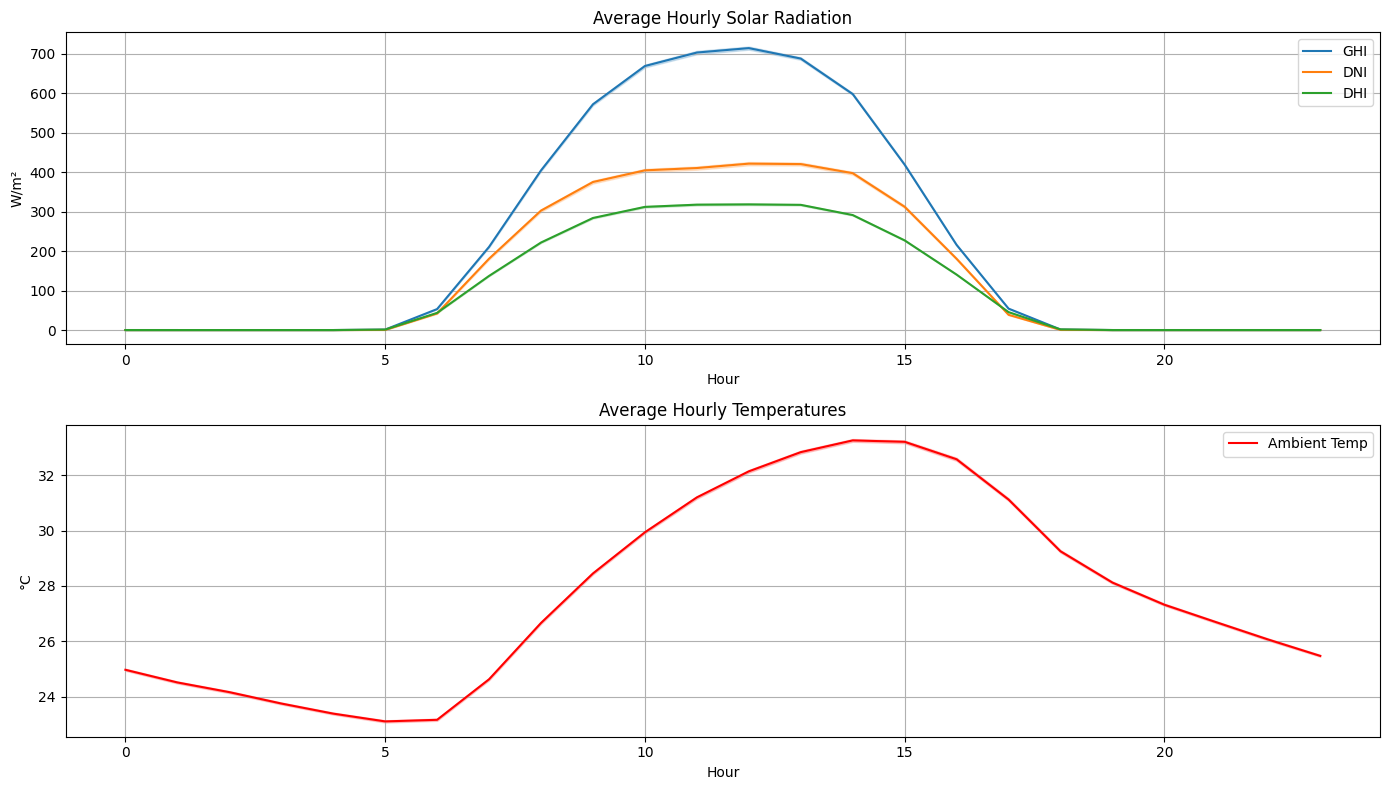

In [12]:
plt.figure(figsize=(14, 8))

# Solar metrics
plt.subplot(2,1,1)
sns.lineplot(data=df, x='Hour', y='GHI', label='GHI')
sns.lineplot(data=df, x='Hour', y='DNI', label='DNI')
sns.lineplot(data=df, x='Hour', y='DHI', label='DHI')
plt.title('Average Hourly Solar Radiation')
plt.ylabel('W/m²')
plt.grid(True)

# Temperature
plt.subplot(2,1,2)
sns.lineplot(data=df, x='Hour', y='Tamb', color='red', label='Ambient Temp')
plt.title('Average Hourly Temperatures')
plt.ylabel('°C')
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.2 Monthly Trends Analysis

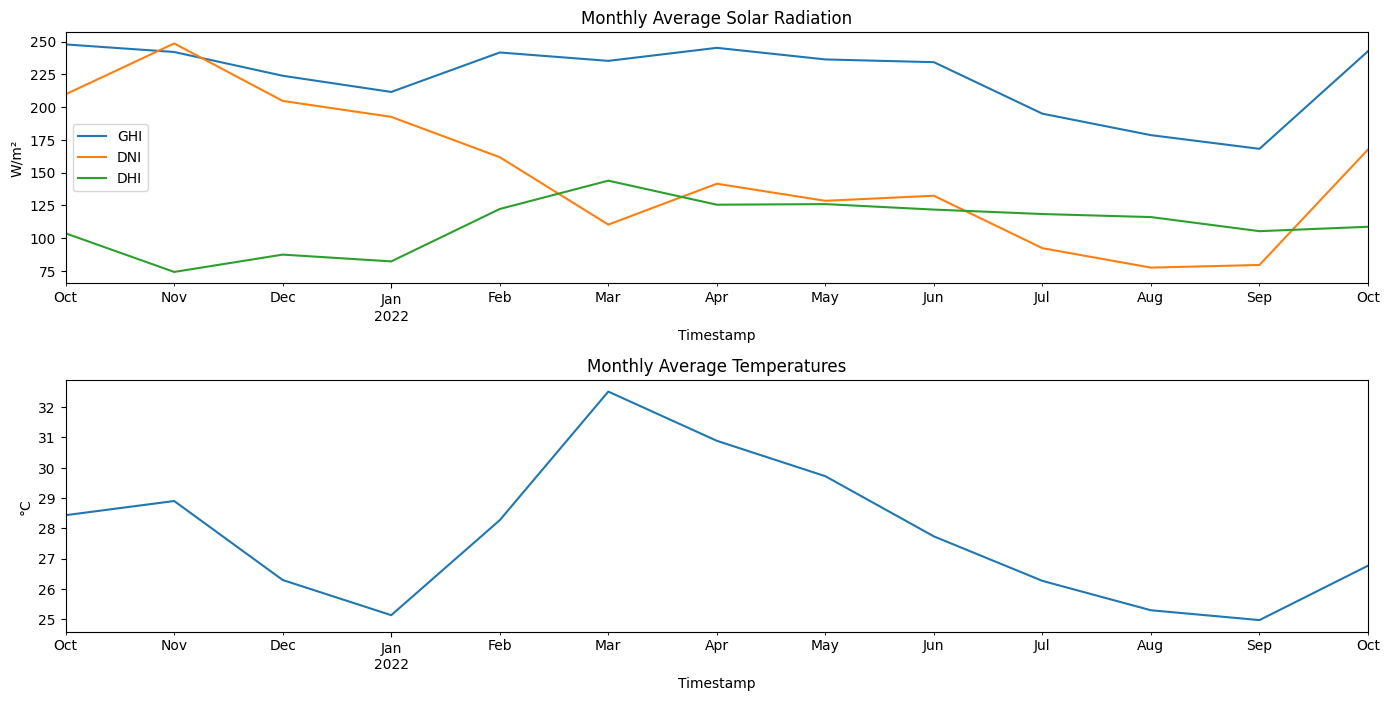

In [13]:
plt.figure(figsize=(14, 10))

# Monthly solar aggregation
plt.subplot(3,1,1)
df.resample('ME')['GHI','DNI','DHI'].mean().plot(ax=plt.gca())
plt.title('Monthly Average Solar Radiation')
plt.ylabel('W/m²')

# Temperature comparison
plt.subplot(3,1,2)
df.resample('ME')['Tamb'].mean().plot(ax=plt.gca())
plt.title('Monthly Average Temperatures')
plt.ylabel('°C')

plt.tight_layout()
plt.show()

## 4. Cleaning Impact

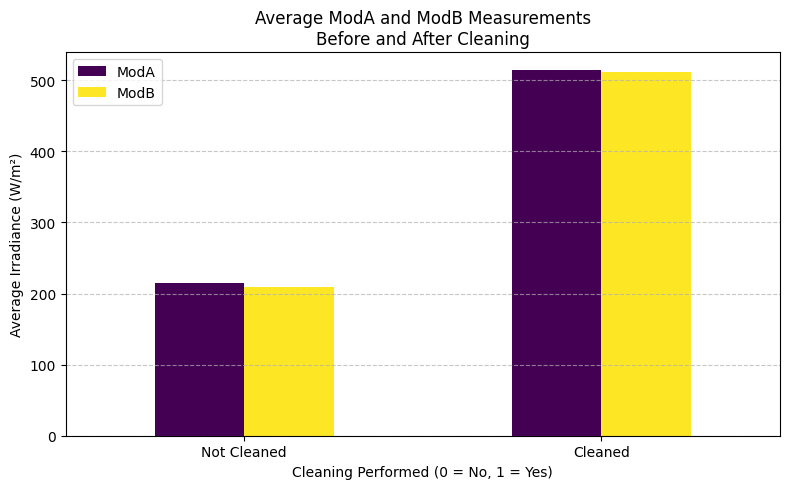

In [14]:
# Group by 'Cleaning' flag and compute mean for ModA and ModB
cleaning_group = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plotting
cleaning_group.plot(kind='bar', figsize=(8, 5), colormap='viridis')
plt.title("Average ModA and ModB Measurements\nBefore and After Cleaning")
plt.xlabel("Cleaning Performed (0 = No, 1 = Yes)")
plt.ylabel("Average Irradiance (W/m²)")
plt.xticks([0, 1], ['Not Cleaned', 'Cleaned'], rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Correlation & Relationship Analysis

### 5.1 Heatmap of correlations (GHI, DNI, DHI, TModA, TModB)

<Axes: >

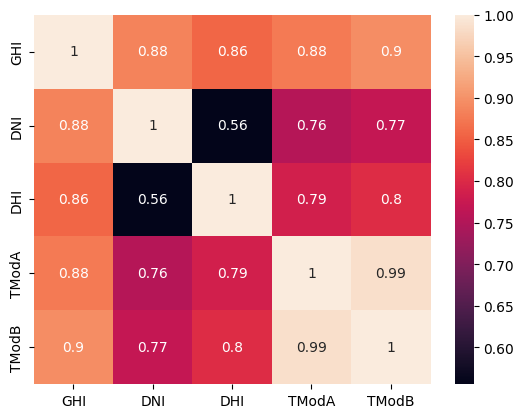

In [15]:
sns.heatmap(df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True)

### 5.2 Scatter plot of WS, WSgust, WD vs. GHI

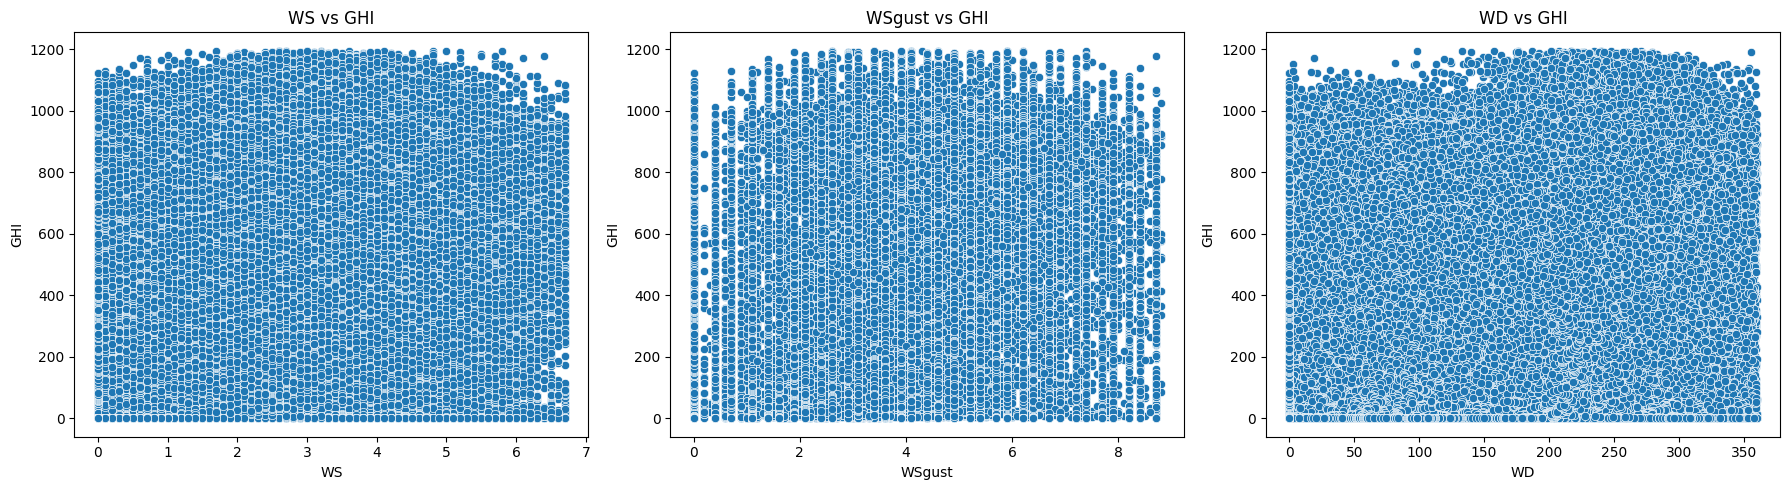

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='WS', y='GHI', ax=axs[0])
axs[0].set_title("WS vs GHI")

sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axs[1])
axs[1].set_title("WSgust vs GHI")

sns.scatterplot(data=df, x='WD', y='GHI', ax=axs[2])
axs[2].set_title("WD vs GHI")

plt.tight_layout()
plt.show()


### 5.3 Scatter plot of RH vs. Tamb and RH vs. GHI

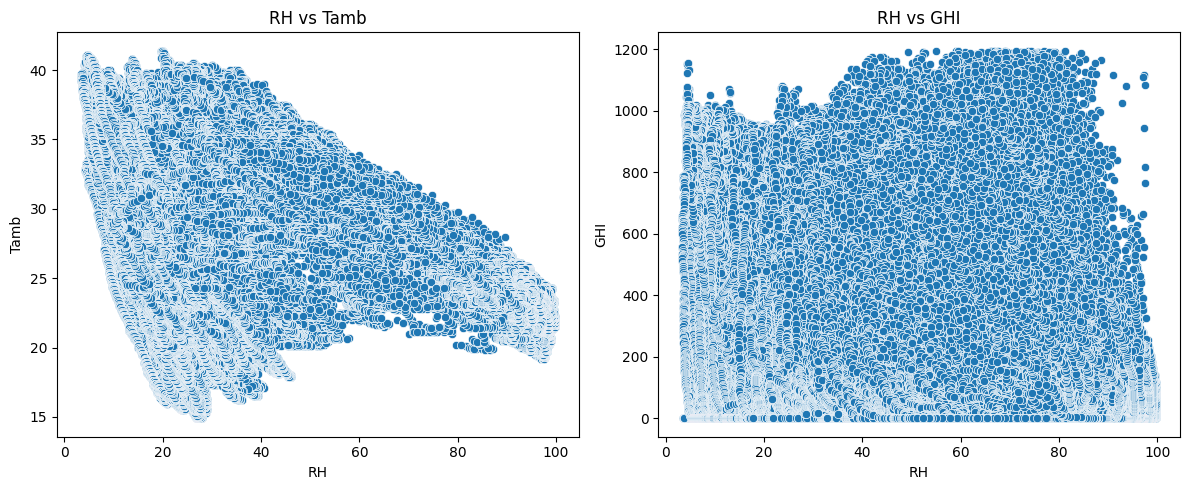

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df, x='RH', y='Tamb', ax=axs[0])
axs[0].set_title("RH vs Tamb")

sns.scatterplot(data=df, x='RH', y='GHI', ax=axs[1])
axs[1].set_title("RH vs GHI")

plt.tight_layout()
plt.show()


# 6. Wind & Distribution Analysis

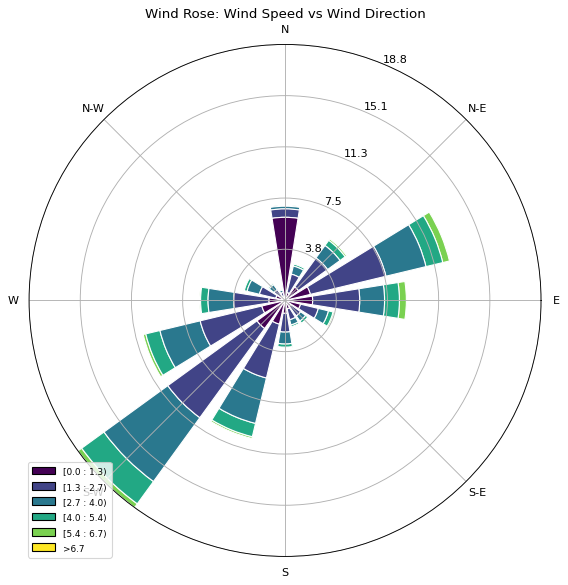

In [18]:
# Create windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("Wind Rose: Wind Speed vs Wind Direction")
plt.show()


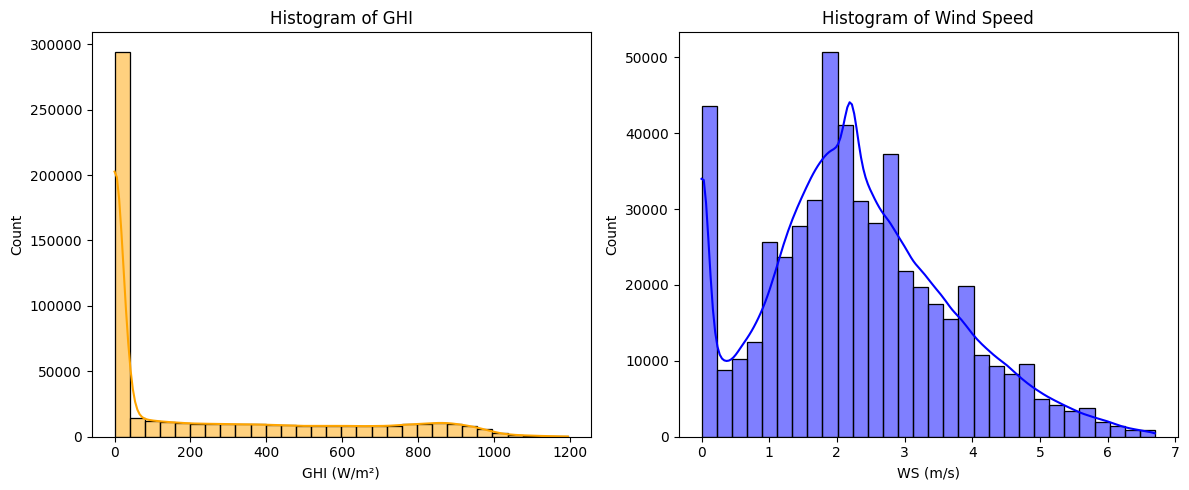

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for GHI
sns.histplot(df['GHI'], bins=30, kde=True, ax=axs[0], color='orange')
axs[0].set_title("Histogram of GHI")
axs[0].set_xlabel("GHI (W/m²)")

# Histogram for WS
sns.histplot(df['WS'], bins=30, kde=True, ax=axs[1], color='blue')
axs[1].set_title("Histogram of Wind Speed")
axs[1].set_xlabel("WS (m/s)")

plt.tight_layout()
plt.show()

## 7. Temperature Analysis

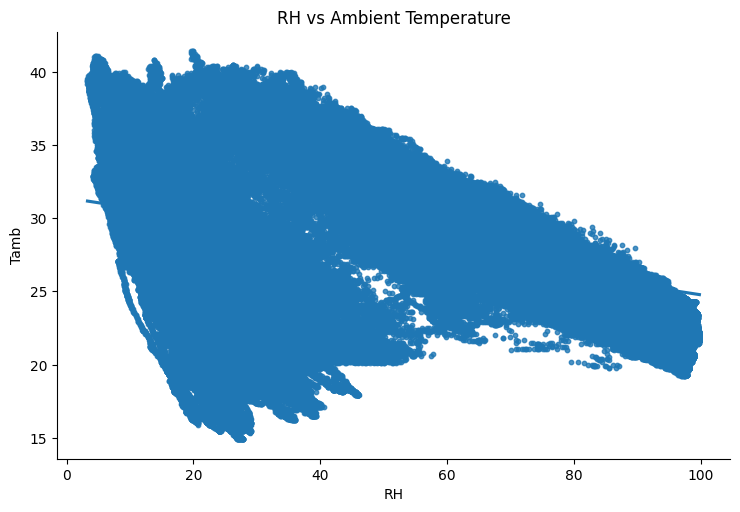

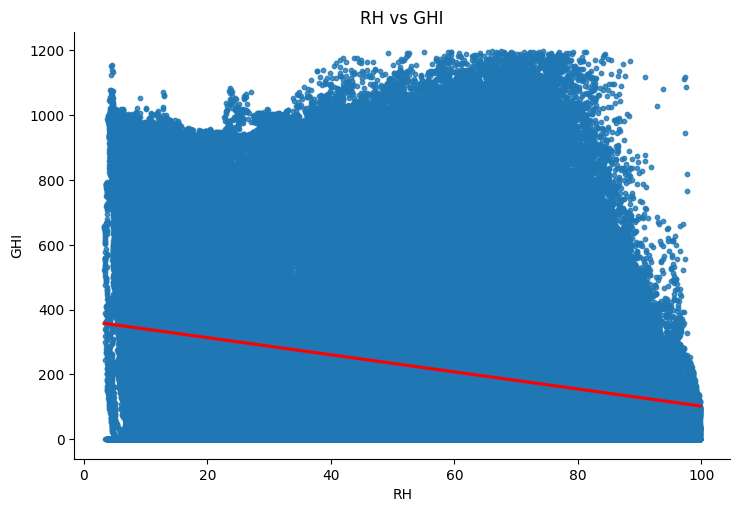

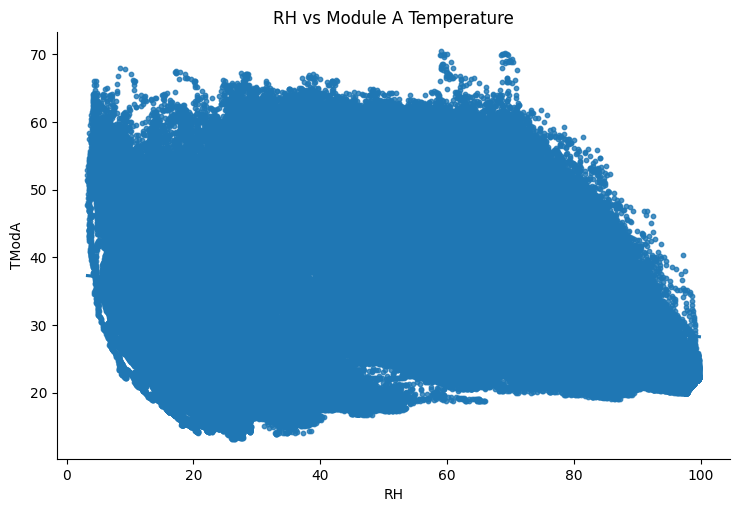

In [20]:
# how relative humidity (RH) might influence temperature readings and solar radiation

# RH vs Tamb
sns.lmplot(data=df, x='RH', y='Tamb', aspect=1.5, scatter_kws={"s": 10})
plt.title("RH vs Ambient Temperature")
plt.show()

# RH vs GHI
sns.lmplot(data=df, x='RH', y='GHI', aspect=1.5, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title("RH vs GHI")
plt.show()

# RH vs TModA
sns.lmplot(data=df, x='RH', y='TModA', aspect=1.5, scatter_kws={"s": 10})
plt.title("RH vs Module A Temperature")
plt.show()

## 8. Bubble Chart

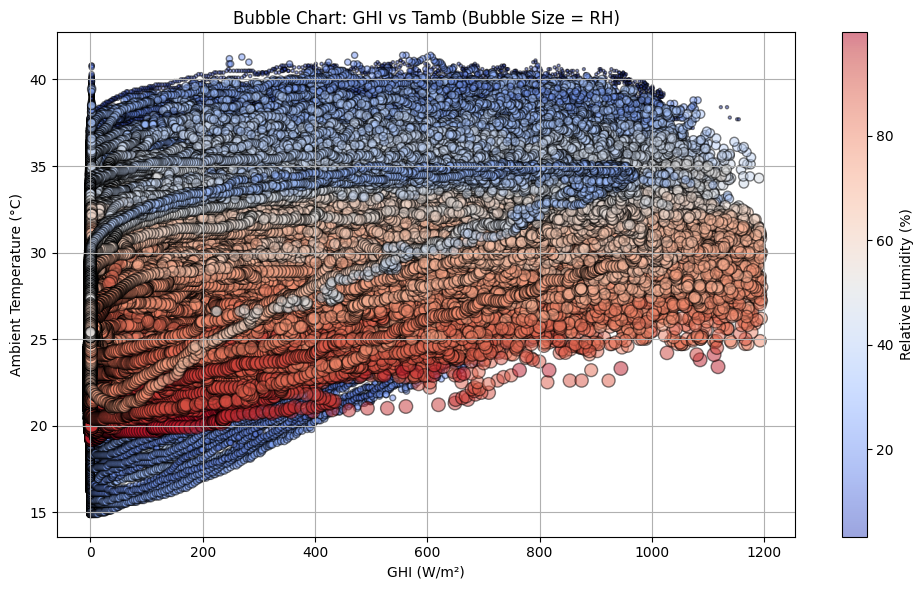

In [21]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['GHI'],
    df['Tamb'],
    s=df['RH'],  # Bubble size
    alpha=0.5,
    c=df['RH'],
    cmap='coolwarm',
    edgecolors='k'
)
plt.colorbar(scatter, label='Relative Humidity (%)')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Bubble Chart: GHI vs Tamb (Bubble Size = RH)')
plt.grid(True)
plt.tight_layout()
plt.show()
